In [210]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import shapefile as shp
import datetime 
import warnings
xr.set_options(keep_attrs=True)
client_runs   = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [211]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = False
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 48                           # number of dask workers
parallel_nprc_bin = parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 200                          # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path         = '/albedo/work/user/pscholz/data_cmip6_LR/core/'
save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
input_paths.append('/albedo/work/user/pscholz/data_cmip6_LR/')

input_names   = list()
input_names.append('piControl')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl     = None
do_allcycl = False
which_model= 'AWI-ESM-1-1-LR'
which_run  = 'piControl'
which_enmem= 'r1i1p1f1'
vname      = 'tos'
year       = [1855, 1954]
dyr        = 10

mon       = None
day       = None
record    = None 
box       = None
depth     = 1000

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
proj              = 'rob' 
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [212]:
# start parallel dask client
if do_parallel and not client_runs:
    from dask.distributed import Client
    
#     # disable dask worker heartbeat --> prevent error ?
#     from dask import config as cfg
#     cfg.set({'distributed.scheduler.worker-ttl': None})
    
    ##import dask
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client_runs = True
    client

## > Load mesh:

In [213]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=False, do_f14cmip6=True)

import matplotlib.pyplot as plt
from   matplotlib.tri    import Triangulation
tri = Triangulation(np.hstack((mesh.n_x,mesh.n_xa)),
                    np.hstack((mesh.n_y,mesh.n_ya)),
                    np.vstack((mesh.e_i[mesh.e_pbnd_0,:],mesh.e_ia)))

#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)

#______________________________________________________________________________________________________        
if save_path is not None:
    if not os.path.isdir(save_path): os.makedirs(save_path)

 > load mesh from *.out files: /albedo/work/user/pscholz/data_cmip6_LR/core
 --> you are in fesom1.4 mode, no nlvls information!
 --> you are in fesom1.4 mode, no elvls information!
 > comp e_area
 > load n_area from griddes.nc
 > compute lsmask
 > save *.shp to /albedo/work/user/pscholz/data_cmip6_LR/core/tripyview_fesom2_core_pbnd.shp
 > augment lsmask
 > save *.shp to /albedo/work/user/pscholz/data_cmip6_LR/core/tripyview_fesom2_core_focus=0.shp
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/data_cmip6_LR/core
 > id              = core
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126859
 > #elem           = 244660
 > #lvls           = 46
___________________________________________


In [214]:
# create list with starting years of loaded cmip6 netcdf files
yr_cs   = np.around(year[0], decimals=-np.log10(np.float32(dyr)))
yr_ce   = np.around(year[1], decimals=-np.log10(np.float32(dyr)))
yr_list = np.unique(np.hstack(( year[0], np.arange(yr_cs+1, yr_ce+2, dyr), year[1]+1 )))

        
#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
         

/albedo/home/pscholz/.conda/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:45: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [215]:
#______________________________________________________________________________________________________
# create list with filepaths that need to be loaded 
data_list = list()
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)): 
    ts = clock.time()
    list_filepath = list()
    for ii in range(0, len(yr_list)-1):
        #______________________________________________________________________________________________
        # create cmip6 filename path
        fname       = f'{vname}_Omon_{which_model}_{which_run}_{which_enmem}_gn_{yr_list[ii]}01-{yr_list[ii+1]-1}12.nc'
        list_filepath.append(os.path.join(datapath, fname))
        print(list_filepath[-1])

    #______________________________________________________________________________________________
    # load cmip6 filename path
    data = tpv.load_data_fesom2(mesh, list_filepath, do_filename=True, do_f14cmip6=True, 
                                vname=vname, year=year, mon=mon, day=day, record=record, 
                                depth=depth, descript=descript, do_info=False, do_parallel=do_parallel)
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
        
    #__________________________________________________________________________________________________    
    # create reference data if given 
    if (ii==0) and (ref_path != None):
        data_ref = data
        if do_reffig: data_list.append(data_ref) 
        continue
        
    #__________________________________________________________________________________________________    
    # compute anomaly 
    if (ref_path != None):
        data_list.append(tpv.do_anomaly(data, data_ref))  
    # compute absolute    
    else:
        data_list.append(data)  
    del(data)
if (ref_path != None): del(data_ref)

/albedo/work/user/pscholz/data_cmip6_LR/tos_Omon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-186012.nc
/albedo/work/user/pscholz/data_cmip6_LR/tos_Omon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_186101-187012.nc
/albedo/work/user/pscholz/data_cmip6_LR/tos_Omon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_187101-188012.nc
/albedo/work/user/pscholz/data_cmip6_LR/tos_Omon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_188101-189012.nc
/albedo/work/user/pscholz/data_cmip6_LR/tos_Omon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_189101-190012.nc
/albedo/work/user/pscholz/data_cmip6_LR/tos_Omon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_190101-191012.nc
/albedo/work/user/pscholz/data_cmip6_LR/tos_Omon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_191101-192012.nc
/albedo/work/user/pscholz/data_cmip6_LR/tos_Omon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_192101-193012.nc
/albedo/work/user/pscholz/data_cmip6_LR/tos_Omon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_193101-194012.nc
/albedo/work/user/pscholz/data_cmip6_LR/tos_Omon_AWI-ESM-1-1-LR_piControl

<IPython.core.display.Javascript object>


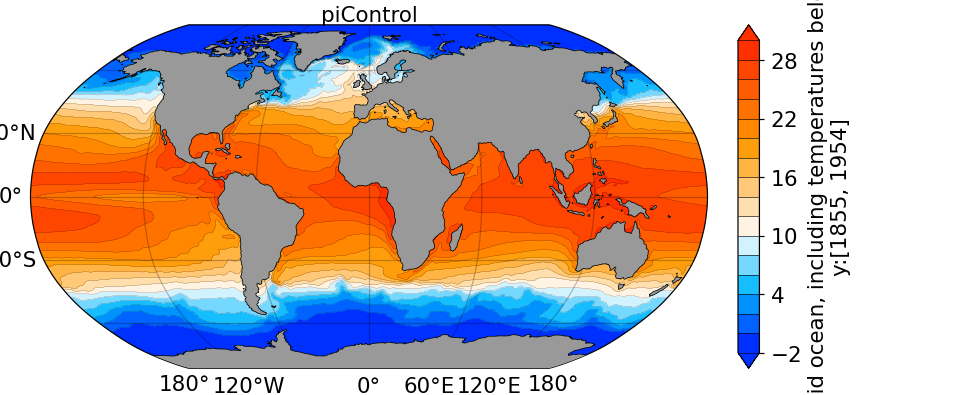

/albedo/home/pscholz/.conda/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_nbagg.py:181: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm('matplotlib', data={'id': self.uuid})


--> cmin/cmax: norm: -1.867348/31.625595, hist: -1.817109/28.326540, fin: -1.817109/28.326540
{'cstr': 'blue2red', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': -1.82, 'cmax': 28.33, 'cref': 10.0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7f7c270369a0>, 'clevel': array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22.,
       24., 26., 28., 30.]), 'clab': array([-2.,  4., 10., 16., 22., 28.])}


In [216]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
ndat   = len(data_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')
    
idx=1 if do_clim else 0       
svname = list(data_list[idx].data_vars)[0]
slabel = data_list[idx][svname].attrs['str_lsave']

#______________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}.{:s}'.format(svname, proj, slabel, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality

#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 

#__________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_hslice(mesh, data_list, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale,  
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(), 
                                do_save=sfpath, save_dpi=save_dpi)  